c:\python27\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
c:\python27\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
c:\python27\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


<IPython.core.display.Javascript object>


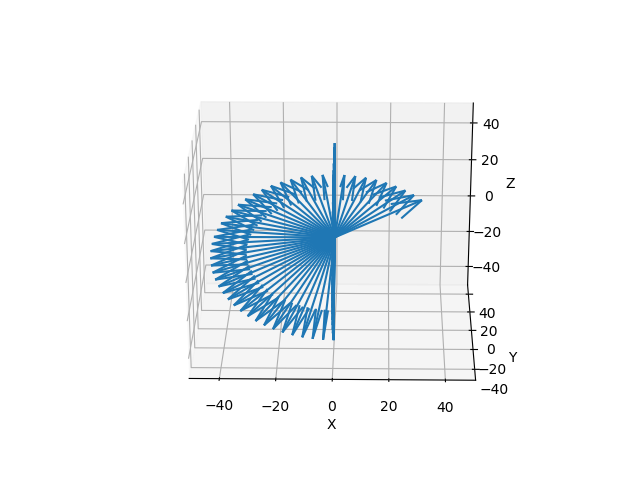

<IPython.core.display.Javascript object>


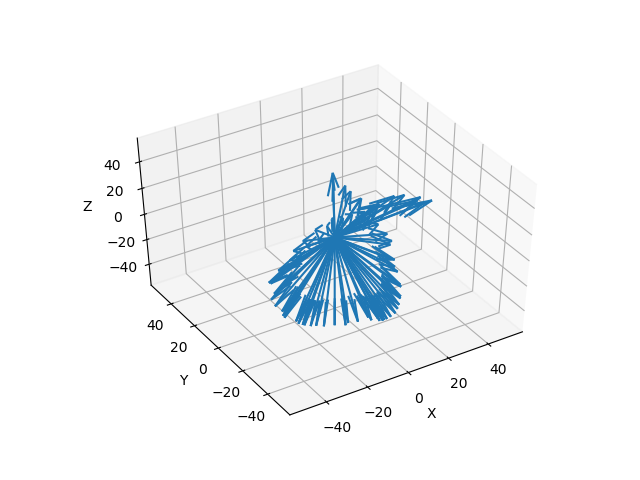

In [66]:
import numpy as np
from math import cos, sin, radians, degrees
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import math
import random 
import time
%matplotlib notebook

def RotY(deg):
    return np.array([[cos(deg),  0, sin(deg)],
                     [    0   ,  1,   0    ],
                     [-sin(deg), 0, cos(deg)]])

def RotZ(deg):
    return np.array([[cos(deg), -sin(deg),  0],
                     [sin(deg), cos(deg) ,  0],
                     [0       , 0        ,  1]])
def RotX(deg):
    return np.array([[1,    0    ,     0    ],
                     [0, cos(deg), -sin(deg)],
                     [0, sin(deg),  cos(deg)]])

def rot2quat(R):
    qw = math.sqrt(1+R[0,0]+R[1,1]+R[2,2])/2.0
    qx = (R[2,1] - R[1,2]) / (4*qw)
    qy = (R[0,2] - R[2,0]) / (4*qw)
    qz = (R[1,0] - R[0,1]) / (4*qw)
    return np.array([[qw,qx,qy,qz]]).T

def create_simulated_data(noise_pos = 0.0, noise_angles = 0.0, only_rotation=False, simple_rotation = False):
    gt_pos = [] #x, y, z
    gt_rot_euler = [] #x, y, z euler degrees
    gt_rot_quat  = [] #quaternion representation
    
    #movement to the right
    x = np.array([[0,0,0]]).T
    for i in range(100):
        gt_pos.append(x)
        if not only_rotation:
            x = x+np.array([[1,0,0]]).T
        else:
            x = np.array([[0,0,0]]).T

    #circular movement
    for i in range(180):
        if not only_rotation:
            a = radians(i)
            R = RotY(a)
            x_r = R.dot(x)
            gt_pos.append(x_r)
        else:
            x_r = np.array([[0,0,0]]).T
            gt_pos.append(x_r)

    #movement to the left
    x = x_r
    for i in range(100):
        if not only_rotation:
            x = x+np.array([[1,0,0]]).T
        else:
            x = np.array([[0,0,0]]).T
        gt_pos.append(x)

    
    if noise_pos >0.0 and not only_rotation:
        for i in range(len(gt_pos)):
            gt_pos[i] = gt_pos[i] + np.random.randn(3,1) * noise_pos
        
    
    #rotation
    r_x, r_y, r_z = 0,0,0
    if not simple_rotation:
        r_x_v, r_y_v, r_z_v = 1,1,1
    else:
        r_x_v, r_y_v, r_z_v = 1,0,0
    for i in range(380):
        if simple_rotation and i>150 and r_y_v ==0:
            r_y_v = 1
            r_x_v = 0
        if i > 240 and r_x_v==1: r_x_v *=-1
        if i > 100 and r_z_v==1: r_z_v *=-1
        r_x += r_x_v
        r_y += r_y_v
        r_z += r_z_v
        angles = np.array([[r_x, r_y, r_z]]).T.astype(np.float32)
        if noise_angles > 0.0:
            angles += np.random.randn(3,1) * noise_angles
        gt_rot_euler.append(angles)
    #get quaternion equivalent
    #For fast compuation I should also do this analytically

    for i in range(len(gt_rot_euler)):
        rx,ry,rz = radians(gt_rot_euler[i][0, 0]), radians(gt_rot_euler[i][1, 0]), radians(gt_rot_euler[i][2, 0])
        R = RotY(ry).dot(RotX(rx)).dot(RotZ(rz))
        q = rot2quat(R)
        gt_rot_quat.append(q)
        
    
    return gt_pos, gt_rot_euler, gt_rot_quat

def animate_moevement(gt_pos, gt_rot, gt_rot_is_mat = False):
    #https://stackoverflow.com/questions/19329039/plotting-animated-quivers-in-python
    #https://github.com/anujgupta82/Musings/blob/master/Dynamic%20or%20Live%20update%20of%20a%20Plot.ipynb
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    def set_axis():
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim(-120 ,120)
        ax.set_ylim(-120 ,120)
        ax.set_zlim(-120 ,120)
    h_v = np.array([[0,0,50]]).T#heading vector
    plt.ion()
    fig.show()
    fig.canvas.draw()
    
    for i in range(0,len(gt_pos), 5):
        pos = gt_pos[i]
        rot = gt_rot[i]
        if animate_moevement.DO_CLEAR_FIGURE:
            ax.clear()
        x, y, z =pos[0],pos[1],pos[2]
        if gt_rot_is_mat == False:
            rx, ry, rz = math.radians(rot[0]),math.radians(rot[1]),math.radians(rot[2])
            R = RotY(ry).dot(RotX(rx)).dot(RotZ(rz))
        else:
            R = gt_rot[i]
        hv_r = R.dot(h_v)
        ax.quiver(x,y,z,hv_r[0],hv_r[1],hv_r[2])
        set_axis()
        fig.canvas.draw()   # draw
        time.sleep(0.005)    #sleep

    plt.show()

gt_pos, gt_rot_euler, gt_rot_quat = create_simulated_data(only_rotation = True, simple_rotation = True)
animate_moevement.DO_CLEAR_FIGURE = False
animate_moevement(gt_pos, gt_rot_euler)

measured_pos, measured_rot_euler, measured_rot_quat = create_simulated_data(noise_pos = 3.0, noise_angles = 2.0, only_rotation = True, simple_rotation = True)
animate_moevement.DO_CLEAR_FIGURE = False
animate_moevement(measured_pos, measured_rot_euler)
print 


In [180]:
import numpy as np
from numpy.linalg import norm, cholesky, inv
from numpy import array
from math import cos, sin, acos, asin
import quaternion
from utils.quatutils import Eul_FromQuat, EulOrdZXYs

def r2q(r, dt = 1.0):
    #rotation vector to quaternion
    if r.shape[0] != 3:
        raise ValueError("in r2q r must have shape (3,) or (3,1)")
    a = norm(r) * dt
    e = r / norm(r) if norm(r) > 0.00001 else r
    e_ = e * sin(a/2.0)
    a_ = cos(a/2.0)

    q =  np.quaternion(a_, e_[0],e_[1],e_[2] )
    return q

def q2r(q, dt=1.0):
    dummy_quat = type(quaternion.as_quat_array([1, 0, 0, 0]))
    if not isinstance(q, dummy_quat):
        raise ValueError("in q2r q must be a quaternion")
    q = quaternion.as_float_array(q)
    q = q / norm(q)
    theta = acos(q[0])
    a = theta * 2.0
    r_norm = a / dt

    e_ = np.array([q[1], q[2], q[3]])
    e = e_ / sin(theta) if sin(theta) > 0.00001 else e_
    r = e * r_norm
    return r

def q2rot(q):
    qw = q[0]
    qx = q[1]
    qy = q[2]
    qz = q[3]
    R = np.zeros((3,3), np.float32)
    R[0,0] = 1 - 2*(qy**2) - 2*(qz**2)
    R[0,1] = 2*qx*qy - 2*qz*qw
    R[0,2] = 2*qx*qz + 2*qy*qw
    R[1,0] = 2*qx*qy + 2*qz*qw
    R[1,1] = 1 - 2*(qx**2) - 2*(qz**2)
    R[1,2] = 2*qy*qz - 2*qx*qw
    R[2,0] = 2*qx*qz - 2*qy*qw
    R[2,1] = 2*qy*qz + 2*qx*qw
    R[2,2] = 1 - 2*(qx**2) - 2*(qy**2)
    return R

STATE_SHAPE = 13
X_QUAT_END = 4
X_ANG_VEL_START = 4
X_ANG_VEL_END = 7
X_POS_START = 7
X_POS_END = 10
X_VEL_START = 10
X_VEL_END = 13
COV_QUAT_END = 3 #quaternion represented as a rotation vector
COV_ANG_VEL_START = 3

Z_QUAT_END = 4
Z_POS_START = 4


class SigmaPoints:

    def __init__(self, W_type, lmbda=None):
        self.W_type = W_type
        #if self.W_type == 2 and lmbda == None:
        #    raise ValueError("lambda must be defined")
        self.alpha = 0.3
        self.k = 1
        self.beta = 2
        self.n = 13
        self.lmbda = (self.alpha**2) * (self.n + self.k) - self.n
        self.counter = 0
        pass

    def compute_W(self, M):
        self.counter +=1
        # compute W points from a matrix M
        if M.shape[0] != M.shape[1] or M.shape[0] != 12:
            raise ValueError("M must be a 12x12 square matrix")
        n = M.shape[0]

        if self.W_type == 1:
            M = (2 * n) * M
            if np.linalg.det(M) < 0.0:
                d, v = np.linalg.eig(M)
                for i in range(d.shape[0]):
                    if d[i] < 0.0:
                        d[i] = 0.000001
                M = v.dot(np.diag(d)).dot(v.T)
            S = cholesky(M)
            W = S.dot(S.T)
        elif self.W_type == 2:
            M = (n + self.lmbda) * M
            if np.linalg.det(M) < 0.0:
                d, v = np.linalg.eig(M)
                for i in range(d.shape[0]):
                    if d[i] < 0.0:
                        d[i] = 0.000001
                M = v.dot(np.diag(d)).dot(v.T)
            S = cholesky(M)
            W = S.dot(S.T)
        return np.hstack((W, -W))

    def compute_X(self, W, x):
        if W.shape[0] != 12 or W.shape[1] != 24:
            raise ValueError("W must be a 12x24 square matrix")
        X = np.zeros((STATE_SHAPE, W.shape[1] + 1))
        qk_m = quaternion.as_quat_array(x[:X_QUAT_END, 0])
        for j in range(W.shape[1]):
            qxj = qk_m * r2q(W[:COV_QUAT_END, j])
            X[:X_QUAT_END, [j]] = quaternion.as_float_array(qxj).reshape(-1, 1)
        X[X_ANG_VEL_START:, :-1] = x[X_ANG_VEL_START:, :] + W[COV_ANG_VEL_START:, :]
        X[:, [-1]] = x
        return X


class UKF_tracker:
    # https://pdfs.semanticscholar.org/3085/aa4779c04898685c1b2d50cdafa98b132d3f.pdf
    def __init__(self, process_noise, measurement_noise, dt):

        self.alpha = 0.3
        self.k = 1
        self.beta = 2
        self.n = 13
        self.lmbda = (self.alpha ** 2) * (self.n + self.k) - self.n

        self.dt = dt

        self.process_noise = process_noise
        self.resetPk()

        # same partial random intialization as Q. R is error in measurement
        Rq = np.eye(3) * (self.dt ** 4 / 4)
        Rp = np.eye(3) * (self.dt ** 4 / 4)
        self.R = np.zeros((6, 6), np.float32)
        self.R[0:3, 0:3] = Rq
        self.R[3:6, 3:6] = Rp
        self.R *= measurement_noise

        self.xk = array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).T.astype(np.float32)

        self.X_generator = SigmaPoints(W_type=1)  # sigma point generator

    def resetPk(self):
        Qq = np.eye(3) * (self.dt ** 4 / 4)  # variance in quaternion represented as rotation vector
        Qw = np.eye(3) * (self.dt ** 2)  # variance in angular speed
        Qqw = np.eye(3) * (self.dt ** 3 / 2)  # covariance between quaternion and angular velocity. only pair dimensions have non-zero value
        Qwq = np.eye(3) * (self.dt ** 3 / 2)  # covariance between angular vel and quaternion. only pair dimensions have non-zero value

        Qp = np.eye(3) * (self.dt ** 4 / 4)  # variance in position
        Qv = np.eye(3) * (self.dt ** 2)  # variance in velocity
        Qpv = np.eye(3) * (self.dt ** 3 / 2)  # covariance between position and velocity. only pair dimensions have non-zero value
        Qvp = np.eye(3) * (self.dt ** 3 / 2)  # covariance between velocity and position. only pair dimensions have non-zero value

        self.Q = np.zeros((12, 12), np.float32)
        self.Q[0:3, 0:3] = Qq
        self.Q[6:9, 6:9] = Qp

        self.Q[0:3, 3:6] = Qqw * 0.2
        self.Q[3:6, 0:3] = Qwq * 0.2  # same as Pqwk
        self.Q[6:9, 9:12] = Qpv * 0.01
        self.Q[9:12, 6:9] = Qvp * 0.01  # same as Ppvk

        self.Q[3:6, 3:6] = Qw * 0.4
        self.Q[9:12, 9:12] = Qv * 0.1

        self.Q *= self.process_noise
        self.Pk = self.Q * 0.001
        
    def fx(self, x):
        # prepare values
        qk = quaternion.as_quat_array(x[:X_QUAT_END, 0])  # quaternion
        wk = x[X_ANG_VEL_START:X_ANG_VEL_END]  # angular velocity
        pk = x[X_POS_START:X_POS_END]  # position
        vk = x[X_VEL_START:X_VEL_END]  # velocity

        # process model
        qk_ = qk * r2q(wk, self.dt)
        wk_ = wk  # predicted angular velocity
        pk_ = pk + vk  # predicted position
        vk_ = vk  # predicted velocity

        # store values
        qk_ = quaternion.as_float_array(qk_).reshape(-1, 1)  # predicted orientation
        x_ = np.vstack((qk_, wk_, pk_, vk_))
        return x_

    def hx(self, x):
        qk_ = x[:X_QUAT_END, [0]]  # quaternion package has  w,x,y,z as in blender
        pk_ = x[X_POS_START:X_POS_END]
        Hx = np.vstack((qk_, pk_))
        return Hx

    def quaternion_mean(self, qk, qxi):
        qt = quaternion.as_quat_array(qk)
        n2 = qxi.shape[1]
        e_prev = np.ones((3, 1))

        # weights = np.zeros(n2,np.float32)
        # weights[-1] = self.lmbda/(self.n +self.lmbda)
        # weights[:-1] = 1/(2*(self.n + self.lmbda))
        for i in range(30):
            ei = np.zeros((3, n2))
            for j in range(n2):
                eq = quaternion.as_quat_array(qxi[:, j]) * qt.inverse()
                ei[:, j] = q2r(eq)
            e = np.mean(ei, axis=1)
            # e = ei * weights
            # e = np.sum(e, axis=1)

            qt = r2q(e) * qt
            if norm(e - e_prev) < 0.01:
                break
            else:
                e_prev = e
        q_avg = quaternion.as_float_array(qt).reshape(-1, 1)
        q_ei = ei
        return q_avg, q_ei

    def unscented_mean_predict_step(self, xk, X):
        q_avg, q_ei = self.quaternion_mean(xk[:X_QUAT_END, 0], X[:X_QUAT_END, :])

        # weights = np.zeros(25, np.float32)
        # weights[-1] = self.lmbda / (self.n + self.lmbda)
        # weights[:-1] = 1 / (2 * (self.n + self.lmbda))
        # wpv_avg = np.sum(X[X_ANG_VEL_START:, :] * weights, axis=1, keepdims=True)
        # weights do not sum up to one. this is why the average does not represent the actual average

        wpv_avg = np.mean(X[X_ANG_VEL_START:, :], axis=1, keepdims=True)
        wpv_ei = X[X_ANG_VEL_START:, :] - wpv_avg

        x_avg = np.vstack((q_avg, wpv_avg))
        x_ei = np.vstack((q_ei, wpv_ei))  # this is noted in paper as W_i^'

        return x_avg, x_ei

    def unscented_cov_predict_step(self, x_ei, Q=None):
        # in paper they do not use Q because of the process model
        # in chapter 10 KF, in the comparative table, there is a Q added to Pk_
        n2 = x_ei.shape[1]

        if Q != None:
            return x_ei.dot(x_ei.T) / n2 + Q
        else:
            # weights = np.zeros(25, np.float32)
            # weights[-1] = self.lmbda / (self.n + self.lmbda) #+ 1 - self.alpha**2 + self.beta
            # weights[:-1] = 1 / (2 * (self.n + self.lmbda))
            # cov = np.zeros((12,12), np.float32)
            # for i in range(x_ei.shape[1]):
            #     cov += weights[i] * x_ei[:,[i]].dot(x_ei[:,[i]].T)
            # return cov
            # weights do not sum up to one. this is why they do not represent the actual average

            return x_ei.dot(x_ei.T) / n2

    def predict(self):
        W = self.X_generator.compute_W(M=self.Pk + self.Q)
        X = self.X_generator.compute_X(W, self.xk)
        Y = np.zeros(X.shape, np.float32)

        for i in range(X.shape[1]):
            Y[:, [i]] = self.fx(X[:, [i]])
        x_, x_ei = self.unscented_mean_predict_step(self.xk, Y)
        P_ = self.unscented_cov_predict_step(x_ei, Q=None)  # should try with P_ = self.unscented_cov(ei, Q=self.Q)
        P_ = (np.abs(P_) + np.abs(P_.T)) / 2.0
        zero_indexes = P_ < 0.000000000001
        P_[zero_indexes] = 0
        return x_, P_, Y, x_ei  # this is noted in paper as W_i^'

    def unscented_mean_update_step(self, Z):
        # I pass xk although it does not have any mathematical reason. It is just a starting point
        # for quaternion average convergence algorithm
        # In fact I might not even need to compute again the average, because it should conver to to same
        # x_ from predict step. because:
        # quaternion part  of hx(Yi) is quaternion part of Yi
        # thus the average of the quaternion should be the same, but here I will start the convergence
        # from another point, just to see if it results to the same
        # i will initialize with unit quaternion
        q_u = np.array([1, 0, 0, 0])
        q_avg, q_ei = self.quaternion_mean(q_u, Z[:Z_QUAT_END, :])

        # weights = np.zeros(25, np.float32)
        # weights[-1] = self.lmbda / (self.n + self.lmbda)
        # weights[:-1] = 1 / (2 * (self.n + self.lmbda))
        # p_avg = np.sum(Z[Z_POS_START:, :] * weights, axis=1, keepdims=True)
        #weights do not sum up to 1. thus this is why hx_avg will not represent the actual average

        p_avg = np.mean(Z[Z_POS_START:, :], axis=1, keepdims=True)
        p_ei = Z[Z_POS_START:, :] - p_avg

        hx_avg = np.vstack((q_avg, p_avg))
        h_ei = np.vstack((q_ei, p_ei))

        return hx_avg, h_ei

    def unscented_cov_update_step(self, h_ei, R):
        n2 = h_ei.shape[1]

        # weights = np.zeros(25, np.float32)
        # weights[-1] = self.lmbda / (self.n + self.lmbda) #+ 1 - self.alpha ** 2 + self.beta
        # weights[:-1] = 1 / (2 * (self.n + self.lmbda))
        # cov = np.zeros((6, 6), np.float32)
        # for i in range(x_ei.shape[1]):
        #     cov += weights[i] * h_ei[:,[i]].dot(h_ei[:,[i]].T)
        # cov = (np.abs(cov) + np.abs(cov.T)) / 2.0
        # zero_indexes = cov < 0.000001
        # cov[zero_indexes] = 0
        # return cov
        #weights do not sum up to one. this is why the average will not represent the actual average

        cov = h_ei.dot(h_ei.T) / n2 + R
        cov = (np.abs(cov) + np.abs(cov.T)) / 2.0
        zero_indexes = cov < 0.000000000001
        cov[zero_indexes] = 0
        return cov

    def measurement_difference(self, z, hx):
        # q2 - q1 = qd #but actually use the proper operators
        # q2 = qd + q1 #but actually use the proper operators
        q_z = quaternion.as_quat_array(z[:Z_QUAT_END, 0])
        q_hx = quaternion.as_quat_array(hx[:Z_QUAT_END, 0])
        q2 = q_z
        q1 = q_hx
        qd = q2 * q1.inverse()
        qd_ = qd
        qd = quaternion.as_float_array(qd).reshape(-1, 1)

        #this x should be equal to q_z
        x =  qd_ * q_hx

        p_z = z[Z_POS_START:, [0]]
        p_hx = hx[Z_POS_START:, [0]]
        pd = p_z - p_hx

        y = np.vstack((qd, pd))
        return y

    def apply_K_to_residual(self, K, y):
        q_y = quaternion.as_quat_array(y[:Z_QUAT_END, 0])
        p_y = y[Z_POS_START:, [0]]
        r_y = q2r(q_y).reshape(-1, 1)
        _y = np.vstack((r_y, p_y))  # z measurement in rotation vector form + position vector

        _Ky = K.dot(_y)  # Ky in rotation vector form + position vector
        q_Ky = r2q(_Ky[:COV_QUAT_END, 0])
        q_Ky = quaternion.as_float_array(q_Ky).reshape(-1, 1)
        wpv_Ky = _Ky[COV_ANG_VEL_START:, [0]]

        Ky = np.vstack((q_Ky, wpv_Ky))
        return Ky

    def state_addition(self, x_, Ky):
        q_x_ = quaternion.as_quat_array(x_[:X_QUAT_END, 0])
        q_Ky = quaternion.as_quat_array(Ky[:X_QUAT_END, 0])
        q_x = q_Ky * q_x_
        q_x = quaternion.as_float_array(q_x).reshape(-1, 1)
        wpv_x_ = x_[X_ANG_VEL_START:, [0]]
        wpv_Ky = Ky[X_ANG_VEL_START:, [0]]

        wpv_x = wpv_x_ + wpv_Ky

        x = np.vstack((q_x, wpv_x))
        return x
    
    

    def update(self, z, Y, x_ei, x_, P_):
        if z is None:
            self.xk = x_
            self.Pk = P_
            return
        if z.shape[0] != 7 or Y.shape[0] != 13 or Y.shape[1] != 25 or x_ei.shape[0] != 12 or x_ei.shape[1] != 25:
            raise ValueError("z must be (7,) or (7,1). Y must be (13,24)")
        Z = np.zeros((z.shape[0], Y.shape[1]), np.float32)
        for i in range(Y.shape[1]):
            Z[:, [i]] = self.hx(Y[:, [i]])
        hx, h_ei = self.unscented_mean_update_step(Z)
        Pz = self.unscented_cov_update_step(h_ei, self.R)

        ############################################
        ##############   Pxz   #####################
        n2 = h_ei.shape[1]
        Pxz = x_ei.dot(h_ei.T) / n2
        # weights do not sum up to one.
        # weights = np.zeros(25, np.float32)
        # weights[-1] = self.lmbda / (self.n + self.lmbda) #+ 1 - self.alpha ** 2 + self.beta
        # weights[:-1] = 1 / (2 * (self.n + self.lmbda))
        # Pxz = np.zeros((12, 6), np.float32)
        # for i in range(x_ei.shape[1]):
        #     Pxz += weights[i] * x_ei[:,[i]].dot(h_ei[:,[i]].T)
        zero_indexes = Pxz < 0.00000000000001
        Pxz[zero_indexes] = 0
        ###########################################
        K = Pxz.dot(inv(Pz))

        y = self.measurement_difference(z, hx)
        Ky = self.apply_K_to_residual(K, y)

        self.xk = self.state_addition(x_, Ky)
        self.Pk = P_ - K.dot(Pz).dot(K.T)

        ###### ensure positive definite
        self.Pk = (np.abs(self.Pk) + np.abs(self.Pk.T))/2.0
        zero_indexes = self.Pk < 0.000000000001
        self.Pk[zero_indexes] = 0
        
        if np.linalg.norm(self.Pk) > 1.0:
            np.linalg.norm(self.Pk)
            self.resetPk()
        
        pass

    # https://forum.unity.com/threads/trivia-q-the-w-in-a-quaternion.2039/
    # https://pdfs.semanticscholar.org/3085/aa4779c04898685c1b2d50cdafa98b132d3f.pdf
    # when implementing the sigma points algorithm, P is 6x6, but state is actually 7x1
    # that means that the 3x1 sigma point that will be deduced from P has some values of rotation and magnitude
    # quoted from the first link: x: is the cosine of the amount of rotation   (the cos of that magnitude)
    #                            (y ,z ,w): is the axis of rotaion.           the normalized values by a formula of cos and shit, check the paper

    # another thing is that the computation of the apriori P is between (X-x_m).dot((X-x_m).T) and does not take into account Q
    # unlike the UKF from the book which does. It may be possible to happen this because of the deduction that Q is applied before the process model
    # NOOOOOOPE. when it says(X-x_m).dot((X-x_m).T) it actually refers to Yi(transformed sigma points)
    # but the idea regarding Q still applies


In [181]:
#this cell will be about checking wheter the difference between two euler angles is reliable
#given 1.  r,y,p: 10, 10, 10   ->Ri
#given 2.  r,y,p: 30, 60, 120  ->Rf
#thus diff r,y,p: 20, 50, 110  ->Rd
#is it true that Rf = Rd * Ri ?

r1,y1,p1 = math.radians(10),math.radians(10),math.radians(10)
r2,y2,p2 = math.radians(30),math.radians(60),math.radians(120)
rd,yd,pd = math.radians(20),math.radians(50),math.radians(110)
R1 = RotY(y1).dot(RotX(p1)).dot(RotZ(r1))
R2 = RotY(y2).dot(RotX(p2)).dot(RotZ(r2))
Rd = RotY(yd).dot(RotX(pd)).dot(RotZ(rd))
#print R1
#print Rd.dot(R1)

# also the mean of quaternions is not easily computed
# check https://pdfs.semanticscholar.org/3085/aa4779c04898685c1b2d50cdafa98b132d3f.pdf
# paragraph after equation 48


<IPython.core.display.Javascript object>


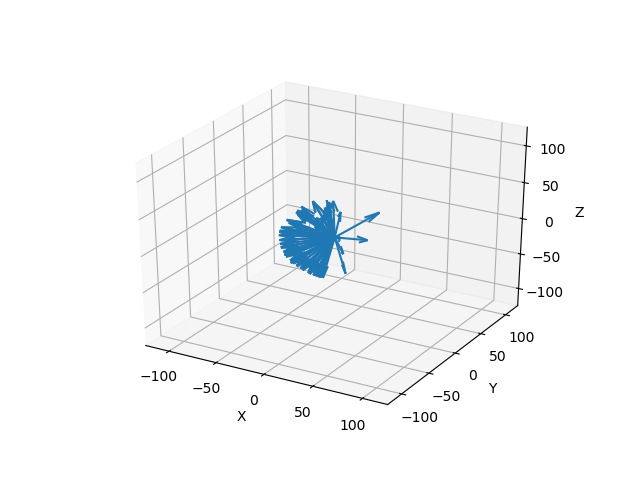

In [182]:
est_pos = []
est_rot = []



tracker = UKF_tracker(process_noise=0.01, measurement_noise=0.00025, dt=1.0)
for i in range(len(measured_rot_quat)):
    
    
    z = np.vstack((measured_rot_quat[i], measured_pos[i]))
    #if i > 300:
    #    z = None

    x_, P_, Y, x_ei = tracker.predict()
    tracker.update(z=z, Y=Y, x_ei=x_ei, x_=x_, P_ = P_)
    xk = tracker.xk

    R_est = q2rot(xk[:X_QUAT_END, 0])
    P_est = xk[X_POS_START:X_POS_END, 0]

    est_pos.append(P_est)
    est_rot.append(R_est)

animate_moevement.DO_CLEAR_FIGURE = False
animate_moevement(est_pos, est_rot, gt_rot_is_mat = True)

In [ ]:
##########################################################################################
##########################################################################################
# I THINK THE NEGATIVE OF A QUATERNION IS THE SAME AS THE ORIGINAL QUATERNION
R = q2rot([-0.9981665611, -0.0350890942, 0.0491280258, 0.0043454715])
print R
q = rot2quat(R)
print q2rot(-np.array(q))
##########################################################################################
##########################################################################################